In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, GRU,LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [83]:
df=pd.read_csv('./HINDUNILVR.csv',index_col='Date',parse_dates=True)

In [84]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,HINDLEVER,EQ,2136.60,2300.0,2307.55,2300.00,2307.55,2307.55,2307.08,24903,5.745330e+12,NaN,NaN,NaN
2000-01-04,HINDLEVER,EQ,2307.55,2381.0,2381.00,2250.00,2270.00,2281.05,2298.15,58514,1.344740e+13,NaN,NaN,NaN
2000-01-05,HINDLEVER,EQ,2281.05,2200.0,2250.00,2105.00,2183.50,2199.90,2211.17,80296,1.775482e+13,NaN,NaN,NaN
2000-01-06,HINDLEVER,EQ,2199.90,2224.9,2360.00,2210.00,2300.00,2288.20,2301.80,190032,4.374157e+13,NaN,NaN,NaN
2000-01-07,HINDLEVER,EQ,2288.20,2300.0,2452.00,2282.25,2395.00,2412.95,2380.24,192582,4.583919e+13,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,HINDUNILVR,EQ,2307.75,2324.0,2369.80,2311.00,2367.70,2360.65,2340.89,1946867,4.557405e+14,85684.0,1289103.0,0.6621
2021-04-27,HINDUNILVR,EQ,2360.65,2363.0,2386.45,2352.95,2378.00,2379.85,2374.40,1668456,3.961583e+14,84641.0,1089882.0,0.6532
2021-04-28,HINDUNILVR,EQ,2379.85,2380.0,2445.00,2366.30,2404.00,2406.55,2414.15,1951215,4.710522e+14,84910.0,1024216.0,0.5249


In [85]:
df['Date']=df.index

In [86]:
start_date='2016-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [87]:
df=df.loc[mask]

In [88]:
df=df.loc[mask]

In [89]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [90]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [91]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [92]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [93]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (1187, 50) Y.shape (1187,)


In [94]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

Bi-LSTM

In [95]:
i=Input(shape=(T,1))
x=Bidirectional(LSTM(200,return_sequences=True))(i)
x=Bidirectional(LSTM(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_lstm=Model(i,x)
model_bi_lstm.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 50, 400)          323200    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 50, 400)          961600    
 nal)                                                            
                                                                 
 global_max_pooling1d_4 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 100)               40100     
                                                           

In [96]:
check_point_bi_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [97]:
model_bi_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [98]:
r=model_bi_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_lstm]
)

Epoch 1/100
26/26 [==============================] - 27s 717ms/step - loss: 265.3671 - mae: 11.9627 - mse: 265.3671 - val_loss: 1591.2510 - val_mae: 25.4928 - val_mse: 1591.2510
Epoch 2/100
26/26 [==============================] - 18s 689ms/step - loss: 260.3511 - mae: 11.7794 - mse: 260.3511 - val_loss: 1589.6028 - val_mae: 25.5024 - val_mse: 1589.6028
Epoch 3/100
26/26 [==============================] - 17s 671ms/step - loss: 259.7397 - mae: 11.7631 - mse: 259.7397 - val_loss: 1588.2540 - val_mae: 25.5367 - val_mse: 1588.2540
Epoch 4/100
26/26 [==============================] - 18s 679ms/step - loss: 258.1136 - mae: 11.7087 - mse: 258.1136 - val_loss: 1586.7020 - val_mae: 25.5402 - val_mse: 1586.7020
Epoch 5/100
26/26 [==============================] - 17s 653ms/step - loss: 256.8552 - mae: 11.7093 - mse: 256.8552 - val_loss: 1588.1725 - val_mae: 25.4335 - val_mse: 1588.1725
Epoch 6/100
26/26 [==============================] - 18s 682ms/step - loss: 257.8546 - mae: 11.7348 - mse: 257

Bi-directional GRU

In [99]:
i=Input(shape=(T,1))
x=Bidirectional(GRU(200,return_sequences=True))(i)
x=Bidirectional(GRU(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_gru=Model(i,x)
model_bi_gru.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 50, 400)          243600    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 50, 400)          722400    
 onal)                                                           
                                                                 
 global_max_pooling1d_5 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_15 (Dense)            (None, 100)               40100     
                                                           

In [100]:
check_point_bi_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [101]:
model_bi_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [102]:
r=model_bi_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_gru]
)

Epoch 1/100
26/26 [==============================] - 24s 609ms/step - loss: 268.9261 - mae: 12.0799 - mse: 268.9261 - val_loss: 1591.4558 - val_mae: 25.5117 - val_mse: 1591.4558
Epoch 2/100
26/26 [==============================] - 14s 550ms/step - loss: 260.4934 - mae: 11.7903 - mse: 260.4934 - val_loss: 1590.8230 - val_mae: 25.4418 - val_mse: 1590.8230
Epoch 3/100
26/26 [==============================] - 14s 549ms/step - loss: 260.5771 - mae: 11.7907 - mse: 260.5771 - val_loss: 1589.1255 - val_mae: 25.5313 - val_mse: 1589.1255
Epoch 4/100
26/26 [==============================] - 14s 545ms/step - loss: 258.7004 - mae: 11.7397 - mse: 258.7004 - val_loss: 1588.7283 - val_mae: 25.5454 - val_mse: 1588.7283
Epoch 5/100
26/26 [==============================] - 14s 532ms/step - loss: 257.7689 - mae: 11.7545 - mse: 257.7689 - val_loss: 1590.4747 - val_mae: 25.4308 - val_mse: 1590.4747
Epoch 6/100
26/26 [==============================] - 14s 534ms/step - loss: 259.0121 - mae: 11.7831 - mse: 259

Predictions

In [103]:
train_idx[:T+1]=False

In [104]:
Ptrain_bi_lstm=model_bi_lstm.predict(Xtrain).flatten()
Ptest_bi_lstm=model_bi_lstm.predict(Xtest).flatten()

In [105]:
Ptrain_bi_gru=model_bi_gru.predict(Xtrain).flatten()
Ptest_bi_gru=model_bi_gru.predict(Xtest).flatten()

In [106]:
df.loc[train_idx,'Diff Bi-LSTM train prediction']=Ptrain_bi_lstm
df.loc[test_idx,'Diff bi-LSTM test prediction']=Ptest_bi_lstm

In [107]:
df.loc[train_idx,'Diff Bi-GRU train prediction']=Ptrain_bi_gru
df.loc[test_idx,'Diff BiGRU test prediction']=Ptest_bi_gru

In [108]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [109]:
last_train=train.iloc[-1]['Prev Close']

In [110]:
df.loc[train_idx,'train_Bi_LSTM']=prev[train_idx]+Ptrain_bi_lstm
df.loc[test_idx,'Prediction_Bi_LSTM']=prev[test_idx]+Ptest_bi_lstm

In [111]:
df.loc[train_idx,'train_Bi_GRU']=prev[train_idx]+Ptrain_bi_gru
df.loc[test_idx,'Prediction_Bi_GRU']=prev[test_idx]+Ptest_bi_gru

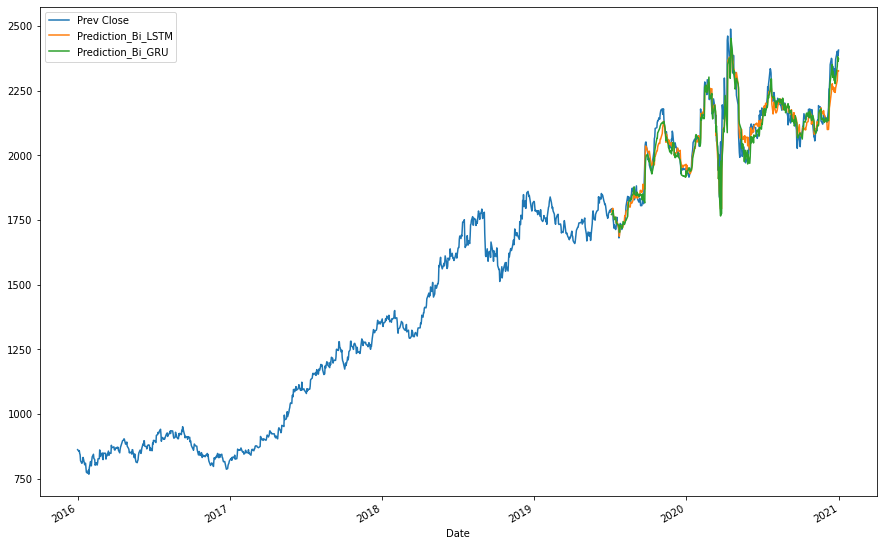

In [112]:
df[[ 'Prev Close','Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

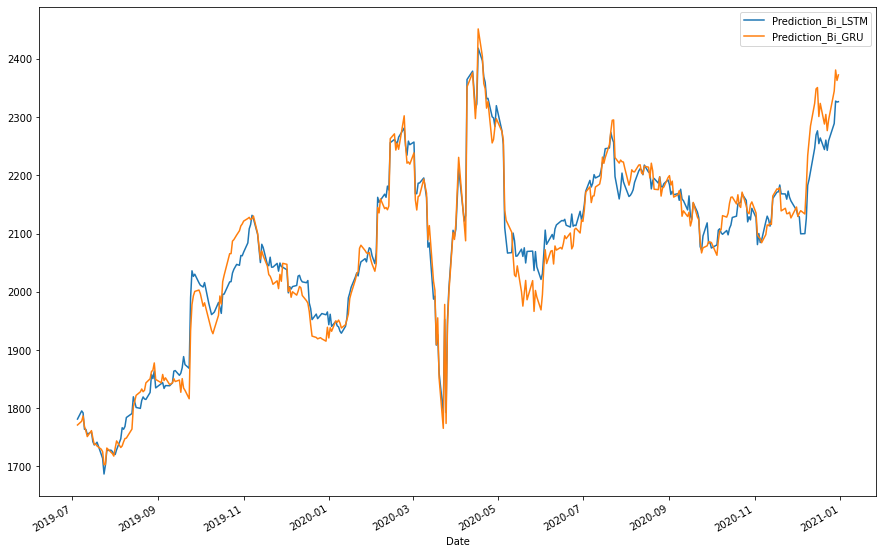

In [113]:
df[[ 'Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

Evaluation

In [114]:
pred_bi_lstm=df['Prediction_Bi_LSTM']
pred_bi_lstm.dropna(inplace=True)

In [115]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_lstm))
print(rmse)

54.20305364080368


In [116]:
error=mean_absolute_error(test['Prev Close'],pred_bi_lstm)
print(error)

37.82181749352922


In [117]:
r2_score(test['Prev Close'],pred_bi_lstm)

0.887233163155775

In [118]:
pred_bi_gru=df['Prediction_Bi_GRU']
pred_bi_gru.dropna(inplace=True)

In [119]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_gru))
print(rmse)

51.15422939932715


In [120]:
error=mean_absolute_error(test['Prev Close'],pred_bi_gru)
print(error)

33.50933296992079


In [121]:
r2_score(test['Prev Close'],pred_bi_gru)

0.8995622480111639